In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69

In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk, SAE_RELU
import tqdm.auto as tqdm
from collections import defaultdict
from numpy import mean
import json
import pandas as pd
import os
from matplotlib import pyplot as plt
import math
from itertools import product


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-14m"
hookpoints = ["gpt_neox.layers.3.mlp.act"]
model_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/53.3M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

## The relationship between k and regularization factor

We need to figure out the amount of active latent neurons in the SAE for different reg factors.

In [4]:


class SaeReluTrainer():
    def __init__(self, model, learning_rate, reg_lambda, hookpoint):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.reg_lambda = reg_lambda



        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.batches = 0
        self.losses = []
        self.pre_reg_losses = []
        self.active_neurons_per_token = []
        self.active_neurons_per_batch = []

    def compute_l1(self, activations):
        return torch.mean(torch.sum(activations, dim=1))

    def compute_active_neurons_per_token(self, activations):
        return torch.mean(torch.sum(activations > 0, dim=1, dtype=torch.float)).item()

    def compute_active_neurons_per_batch(self, activations):
        return torch.sum(torch.sum(activations, dim=0) > 0).item()

    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)

        pre_reg_loss = loss.item()
        self.pre_reg_losses.append(pre_reg_loss)

        activations = self.model.activations
        loss += self.compute_l1(activations) * self.reg_lambda

        active_neurons_per_batch = self.compute_active_neurons_per_batch(activations)
        active_neurons_per_token = self.compute_active_neurons_per_token(activations)

        self.losses.append(loss.item())
        self.active_neurons_per_batch.append(active_neurons_per_batch)
        self.active_neurons_per_token.append(active_neurons_per_token)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.batches += 1
        return loss, pre_reg_loss, active_neurons_per_batch, active_neurons_per_token

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.plot(self.losses, label='Loss')
        ax.plot(self.pre_reg_losses, label='Pre reg loss', color='red')
        ax2 = ax.twinx()
        ax2.plot(self.active_neurons_per_token, label='Active neurons per token', color='orange')
        ax2.plot(self.active_neurons_per_batch, label='Active neurons per batch', color='green')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [5]:
class SaeTopkTrainer():
    def __init__(self, model, learning_rate, hookpoint):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()


        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.batches = 0
        self.losses = []
        self.active_neurons_per_batch = []


    def compute_active_neurons_per_batch(self, activations):
        return len(torch.unique(activations.indices))

    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)

        activations = self.model.activations
        active_neurons_per_batch = self.compute_active_neurons_per_batch(activations)

        self.losses.append(loss.item())
        self.active_neurons_per_batch.append(active_neurons_per_batch)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.batches += 1
        return loss, active_neurons_per_batch

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.plot(self.losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(self.active_neurons_per_batch, label='Active neurons per batch', color='green')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [6]:
relu_grid = defaultdict(dict)

same_Ws = [True, False]
pre_encoder_biases = [True, False]

input_size = model.config.intermediate_size

expansion_factor = 4

for same_W in same_Ws:
    same_W_key = 'same_W' if same_W else 'not_same_W'
    for pre_encoder_bias in pre_encoder_biases:
        pre_encoder_bias_key = 'pre_encoder_bias' if pre_encoder_bias else 'not_pre_encoder_bias'

        meta_data = {
            'input_size': input_size,
            'hidden_size': input_size * expansion_factor,
            'pre_encoder_bias': pre_encoder_bias,
            'same_W': same_W
        }

        sae_relu_trainers = []
        reg_lambdas = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005]
        for reg_lambda in reg_lambdas:
            sae_relu = SAE_RELU(meta_data=meta_data).to(device)
            sae_relu_trainer = SaeReluTrainer(sae_relu, 1e-3, reg_lambda, hookpoints[0])
            sae_relu_trainers.append(sae_relu_trainer)

        relu_grid[same_W_key][pre_encoder_bias_key] = sae_relu_trainers



In [7]:
topk_grid = defaultdict(dict)

same_Ws = [True, False]
pre_encoder_biases = [True, False]

input_size = model.config.intermediate_size

expansion_factor = 4

for same_W in same_Ws:
    same_W_key = 'same_W' if same_W else 'not_same_W'
    for pre_encoder_bias in pre_encoder_biases:
        pre_encoder_bias_key = 'pre_encoder_bias' if pre_encoder_bias else 'not_pre_encoder_bias'

        sae_topk_trainers = []
        ks = [2, 5, 10, 30, 70, 100]
        for k in ks:
            meta_data = {
                'input_size': input_size,
                'hidden_size': input_size * expansion_factor,
                'pre_encoder_bias': pre_encoder_bias,
                'same_W': same_W,
                'k': k
            }
            sae_topk = SAE_topk(meta_data=meta_data).to(device)
            sae_topk_trainer = SaeTopkTrainer(sae_topk, 1e-3, hookpoints[0])
            sae_topk_trainers.append(sae_topk_trainer)

        topk_grid[same_W_key][pre_encoder_bias_key] = sae_topk_trainers


In [8]:
for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    activation = activations[sae_relu_trainer.hookpoint]
    label = activation.detach()
    for sae_relu_trainer in relu_grid['same_W']['not_pre_encoder_bias']:
        loss, pre_reg_loss, active_neurons_per_batch, active_neurons_per_token = sae_relu_trainer.train_step(activation, label)
        # print(f'{loss}\t{pre_reg_loss}\t{active_neurons_per_batch}\t{active_neurons_per_token}\t', end='')

    for sae_topk_trainer in topk_grid['same_W']['not_pre_encoder_bias']:
        loss, active_neurons_per_batch = sae_topk_trainer.train_step(activation, label)
        # print(f'{loss}\t{active_neurons_per_batch}\t', end='')

    for sae_relu_trainer in relu_grid['not_same_W']['not_pre_encoder_bias']:
        loss, pre_reg_loss, active_neurons_per_batch, active_neurons_per_token = sae_relu_trainer.train_step(activation, label)
        # print(f'{loss}\t{pre_reg_loss}\t{active_neurons_per_batch}\t{active_neurons_per_token}\t', end='')

    for sae_topk_trainer in topk_grid['not_same_W']['not_pre_encoder_bias']:
        loss, active_neurons_per_batch = sae_topk_trainer.train_step(activation, label)
        # print(f'{loss}\t{active_neurons_per_batch}\t', end='')

    for sae_relu_trainer in relu_grid['same_W']['pre_encoder_bias']:
        loss, pre_reg_loss, active_neurons_per_batch, active_neurons_per_token = sae_relu_trainer.train_step(activation, label)
        # print(f'{loss}\t{pre_reg_loss}\t{active_neurons_per_batch}\t{active_neurons_per_token}\t', end='')

    for sae_topk_trainer in topk_grid['same_W']['pre_encoder_bias']:
        loss, active_neurons_per_batch = sae_topk_trainer.train_step(activation, label)
        # print(f'{loss}\t{active_neurons_per_batch}\t', end='')

    for sae_relu_trainer in relu_grid['not_same_W']['pre_encoder_bias']:
        loss, pre_reg_loss, active_neurons_per_batch, active_neurons_per_token = sae_relu_trainer.train_step(activation, label)
        # print(f'{loss}\t{pre_reg_loss}\t{active_neurons_per_batch}\t{active_neurons_per_token}\t', end='')

    for sae_topk_trainer in topk_grid['not_same_W']['pre_encoder_bias']:
        loss, active_neurons_per_batch = sae_topk_trainer.train_step(activation, label)
        # print(f'{loss}\t{active_neurons_per_batch}\t', end='')


    # print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

In [9]:
out_dict = {'topk': defaultdict(dict), 'relu': defaultdict(dict)}

In [10]:
for same_w in relu_grid.keys():
    for pre_encoder_bias in relu_grid[same_w].keys():
        trainers = relu_grid[same_w][pre_encoder_bias]
        out_dict['relu'][same_w][pre_encoder_bias] = {
            'active_neurons_per_token': [mean(trainer.active_neurons_per_token[-11:-1]) for trainer in trainers],
            'active_neurons_per_batch': [mean(trainer.active_neurons_per_batch[-11:-1]) for trainer in trainers],
            'loss': [mean(trainer.pre_reg_losses[-11:-1]) for trainer in trainers]
        }

for same_w in topk_grid.keys():
    for pre_encoder_bias in topk_grid[same_w].keys():
        trainers = topk_grid[same_w][pre_encoder_bias]
        out_dict['topk'][same_w][pre_encoder_bias] = {
            'active_neurons_per_token': ks,
            'active_neurons_per_batch': [mean(trainer.active_neurons_per_batch[-11:-1]) for trainer in trainers],
            'loss': [mean(trainer.losses[-11:-1]) for trainer in trainers]
        }

In [11]:
import json

with open('grid_search_results.json', 'w') as file:
    json.dump(out_dict, file, indent=4)

In [12]:
!git add grid_search_results.json
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   grid_search_results.json



In [14]:
!git config --global user.email "mk@sibbesen.dk"
!git config --global user.name "Markus Sibbesen"

In [15]:
!git commit -m "grid search results"

[main 798c18b] grid search results
 1 file changed, 222 insertions(+)
 create mode 100644 grid_search_results.json


In [16]:

!git push

Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.47 KiB | 1.47 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkusSibbesen/mechinterp_research_project.git
   5349383..798c18b  main -> main


In [17]:
relu_samew_not_pre = relu_grid['same_W']['not_pre_encoder_bias']
relu_samew_pre = relu_grid['same_W']['pre_encoder_bias']
relu_not_samew_not_pre = relu_grid['not_same_W']['not_pre_encoder_bias']
relu_not_samew_pre = relu_grid['not_same_W']['pre_encoder_bias']

topk_samew_not_pre = topk_grid['same_W']['not_pre_encoder_bias']
topk_samew_pre = topk_grid['same_W']['pre_encoder_bias']
topk_not_samew_not_pre = topk_grid['not_same_W']['not_pre_encoder_bias']
topk_not_samew_pre = topk_grid['not_same_W']['pre_encoder_bias']

In [18]:
def get_active_n_token(trainers):
    return [mean(trainer.active_neurons_per_token[-11:-2]) for trainer in trainers]
def get_active_n_batch(trainers):
    return [mean(trainer.active_neurons_per_batch[-11:-2]) for trainer in trainers]
def get_loss_topk(trainers):
    return [mean(trainer.losses[-11:-2]) for trainer in trainers]
def get_loss_relu(trainers):
    return [mean(trainer.pre_reg_losses[-11:-2]) for trainer in trainers]

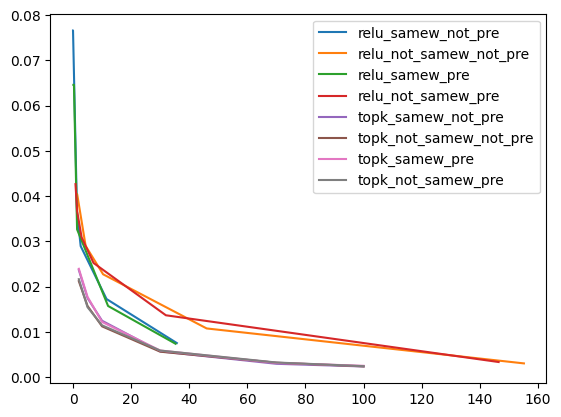

In [19]:
trainers = relu_samew_not_pre
plt.plot(get_active_n_token(trainers), get_loss_relu(trainers), label='relu_samew_not_pre')

trainers = relu_not_samew_not_pre
plt.plot(get_active_n_token(trainers), get_loss_relu(trainers), label='relu_not_samew_not_pre')

trainers = relu_samew_pre
plt.plot(get_active_n_token(trainers), get_loss_relu(trainers), label='relu_samew_pre')

trainers = relu_not_samew_pre
plt.plot(get_active_n_token(trainers), get_loss_relu(trainers), label='relu_not_samew_pre')


trainers = topk_samew_not_pre
plt.plot(ks, get_loss_topk(trainers), label='topk_samew_not_pre')

trainers = topk_not_samew_not_pre
plt.plot(ks, get_loss_topk(trainers), label='topk_not_samew_not_pre')

trainers = topk_samew_pre
plt.plot(ks, get_loss_topk(trainers), label='topk_samew_pre')

trainers = topk_not_samew_pre
plt.plot(ks, get_loss_topk(trainers), label='topk_not_samew_pre')

plt.legend()

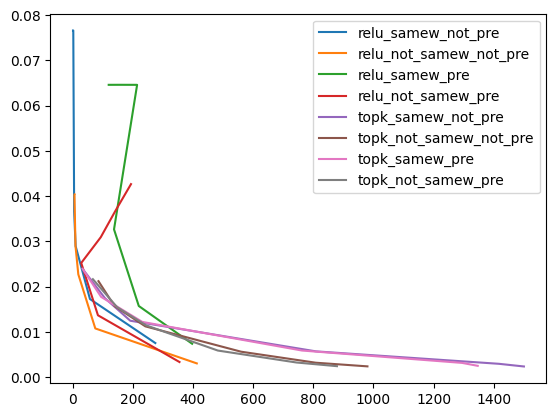

In [20]:
trainers = relu_samew_not_pre
plt.plot(get_active_n_batch(trainers), get_loss_relu(trainers), label='relu_samew_not_pre')

trainers = relu_not_samew_not_pre
plt.plot(get_active_n_batch(trainers), get_loss_relu(trainers), label='relu_not_samew_not_pre')

trainers = relu_samew_pre
plt.plot(get_active_n_batch(trainers), get_loss_relu(trainers), label='relu_samew_pre')

trainers = relu_not_samew_pre
plt.plot(get_active_n_batch(trainers), get_loss_relu(trainers), label='relu_not_samew_pre')


trainers = topk_samew_not_pre
plt.plot(get_active_n_batch(trainers), get_loss_topk(trainers), label='topk_samew_not_pre')

trainers = topk_not_samew_not_pre
plt.plot(get_active_n_batch(trainers), get_loss_topk(trainers), label='topk_not_samew_not_pre')

trainers = topk_samew_pre
plt.plot(get_active_n_batch(trainers), get_loss_topk(trainers), label='topk_samew_pre')

trainers = topk_not_samew_pre
plt.plot(get_active_n_batch(trainers), get_loss_topk(trainers), label='topk_not_samew_pre')

plt.legend()

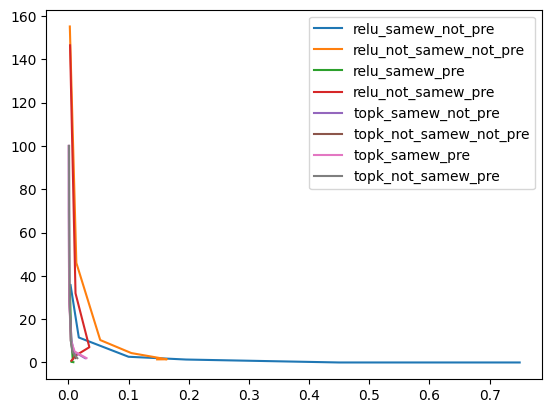

In [21]:
trainers = relu_samew_not_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , get_active_n_token(trainers), label='relu_samew_not_pre')

trainers = relu_not_samew_not_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , get_active_n_token(trainers), label='relu_not_samew_not_pre')

trainers = relu_samew_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , get_active_n_token(trainers), label='relu_samew_pre')

trainers = relu_not_samew_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , get_active_n_token(trainers), label='relu_not_samew_pre')


trainers = topk_samew_not_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , ks, label='topk_samew_not_pre')

trainers = topk_not_samew_not_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , ks, label='topk_not_samew_not_pre')

trainers = topk_samew_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , ks, label='topk_samew_pre')

trainers = topk_not_samew_pre
plt.plot([1 / x for x in get_active_n_batch(trainers)] , ks, label='topk_not_samew_pre')

plt.legend()

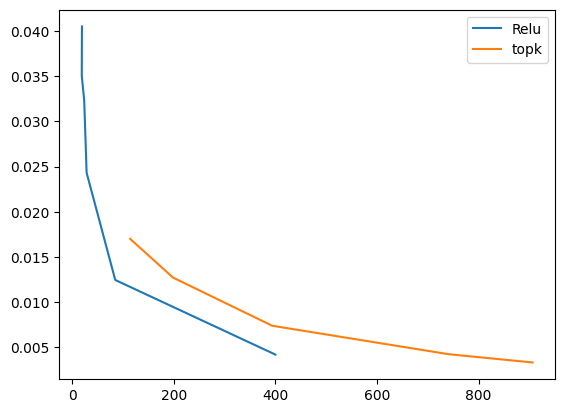

In [ ]:
frontier_relu_x = [mean(sae_relu_trainer.active_neurons_per_batch[-11:-2]) for sae_relu_trainer in sae_relu_trainers]
frontier_relu_y = [mean(sae_relu_trainer.pre_reg_losses[-11:-2]) for sae_relu_trainer in sae_relu_trainers]

plt.plot(frontier_relu_x, frontier_relu_y, label='Relu')


frontier_topk_x = [mean(sae_topk_trainer.active_neurons_per_batch[-11:-2]) for sae_topk_trainer in sae_topk_trainers]
frontier_topk_y = [mean(sae_topk_trainer.losses[-11:-2]) for sae_topk_trainer in sae_topk_trainers]

plt.plot(frontier_topk_x, frontier_topk_y, label='topk')
plt.legend()

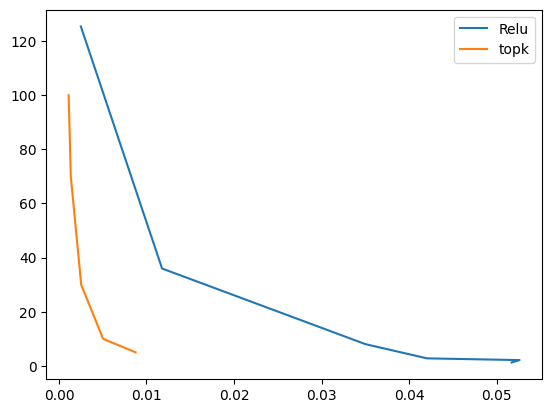

In [ ]:
frontier_relu_x = [1 / mean(sae_relu_trainer.active_neurons_per_batch[-11:-2]) for sae_relu_trainer in sae_relu_trainers]
frontier_relu_y = [mean(sae_relu_trainer.active_neurons_per_token[-11:-2]) for sae_relu_trainer in sae_relu_trainers]

plt.plot(frontier_relu_x, frontier_relu_y, label='Relu')


frontier_topk_x = [1 /mean(sae_topk_trainer.active_neurons_per_batch[-11:-2]) for sae_topk_trainer in sae_topk_trainers]
frontier_topk_y = ks

plt.plot(frontier_topk_x, frontier_topk_y, label='topk')
plt.legend()

In [ ]:
torch.sum(torch.sum(activations, dim=0) > 0).item()

1924

In [ ]:
activations = sae_relu.activations

In [ ]:
activations ** 2

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<PowBackward0>)

In [ ]:
torch.sum(activations > 0, dim=1)

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 121,   0,   0,   0,   0,   0,  

In [ ]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': int(math.sqrt(input_size*expansion_factor)),
    "pre_encoder_bias": True,
    "activation_function": "topk"
}



In [ ]:
grid_relu = {
    "input_size": [input_size],
    "hidden_size": [input_size * expansion_factor],
    "lambda_l1": [1,0.1,0.01],
    "k": [int(math.sqrt(input_size*expansion_factor))],
    "activation_function": ["relu"],
    "pre_encoder_bias": [True, False]
}
grid_topk = {
    "input_size": [input_size],
    "hidden_size": [input_size * expansion_factor],
    "k": [int(math.sqrt(input_size*expansion_factor))],
    "activation_function": ["topk"],
    "pre_encoder_bias": [True, False]
}



def generate_meta_data_combinations(grid_search):
    # Get the keys and values (lists of possible values) from the grid_search dictionary
    keys, values = zip(*grid_search.items())

    # Generate all combinations
    all_combinations = [dict(zip(keys, combination)) for combination in product(*values)]

    return all_combinations

#We compute the gridsearch separately for the two activation functions since topk does not have a lambda_l1 parameter
grid_search_relu = generate_meta_data_combinations(grid_relu)
grid_search_topk = generate_meta_data_combinations(grid_topk)
grid_search = grid_search_topk + grid_search_relu
grid_search = grid_search[:4]

In [ ]:
grid_search

[{'input_size': 512,
  'hidden_size': 2048,
  'k': 45,
  'activation_function': 'topk',
  'pre_encoder_bias': True},
 {'input_size': 512,
  'hidden_size': 2048,
  'k': 45,
  'activation_function': 'topk',
  'pre_encoder_bias': False},
 {'input_size': 512,
  'hidden_size': 2048,
  'lambda_l1': 1,
  'k': 45,
  'activation_function': 'relu',
  'pre_encoder_bias': True},
 {'input_size': 512,
  'hidden_size': 2048,
  'lambda_l1': 1,
  'k': 45,
  'activation_function': 'relu',
  'pre_encoder_bias': False}]

In [ ]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint
        self.meta_data = meta_data
        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []

    def compute_l1(self):
        amount_of_weights = self.model.W.shape[0] * self.model.W.shape[1]
        encoder_l1_loss = self.model.W.abs().sum()/amount_of_weights
        decoder_l1_loss = self.model.WT.abs().sum()/amount_of_weights


        return float((encoder_l1_loss + decoder_l1_loss) * self.meta_data["lambda_l1"])

    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        if self.meta_data["activation_function"] == "relu":
            print("l1",self.compute_l1())
            loss += self.compute_l1()


        active_neurons = self.model.active_neurons

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [ ]:
d = defaultdict(list)
sae_trainer_list =[]
for meta_data in grid_search:

    try:
        d["lambda_l1"].append(meta_data["lambda_l1"])
    except:
        d["lambda_l1"].append(None)

    d["activation_function"].append(meta_data["activation_function"])
    d["pre_encoder_bias"].append(meta_data["pre_encoder_bias"])
    sae_trainers = [
        SaeTrainer(meta_data, learning_rate, hookpoint, device)
        for hookpoint in hookpoints
    ]
    loss_list = []
    active_neurons_list = []
    for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
        for sae_trainer in sae_trainers:
            activation = activations[sae_trainer.hookpoint]
            label = activation.detach()
            loss, active_neurons = sae_trainer.train_step(activation, label)
            loss_list.append(loss)
            active_neurons_list.append(active_neurons)
            print(f'{loss}\t{active_neurons}', end='')
        print('')
    #Compute the average loss of the 10 last batches
    last_10_avg_mean_loss = mean([float(x) for x in loss_list[-10:]])
    d["loss"].append(last_10_avg_mean_loss)
    #Compute the average active neurons of the 10 last batches
    last_10_avg_mean_neurons = mean([float(x) for x in active_neurons_list[-10:]])
    d["active_neurons"].append(last_10_avg_mean_neurons)
    sae_trainer_list.append(sae_trainers)

  0%|          | 0/2070 [00:00<?, ?it/s]

0.08555074036121368	443
0.07725958526134491	431
0.07027411460876465	428
0.06462918221950531	418
0.055834535509347916	417
0.051136184483766556	408
0.04494257643818855	414
0.040586113929748535	411
0.03763324022293091	415
0.03553542122244835	412
0.034231845289468765	412
0.03312870115041733	413
0.03165145590901375	414
0.03008691407740116	418
0.027852753177285194	417
0.02687489613890648	417
0.02548070251941681	420
0.02479615993797779	420
0.02424480766057968	423
0.024353520944714546	422
0.02407066524028778	423
0.023494182154536247	422
0.023300914093852043	419
0.02303774654865265	413
0.022406749427318573	407
0.02232811041176319	407
0.02225290611386299	407
0.020993715152144432	404
0.02153537981212139	406
0.020702261477708817	403
0.020563093945384026	410
0.02047526277601719	409
0.019912412390112877	408
0.01844331994652748	409
0.01959824003279209	407
0.018774880096316338	408
0.01850203052163124	410
0.018277736380696297	413
0.01797785982489586	410
0.018571127206087112	414
0.017942892387509346	411

  0%|          | 0/2070 [00:00<?, ?it/s]

0.07644126564264297	470
0.07629353553056717	434
0.07183347642421722	442
0.06323342025279999	443
0.05447908863425255	442
0.05054686963558197	442
0.0448266938328743	434
0.040303993970155716	431
0.03845866769552231	439
0.03694775700569153	434
0.034561753273010254	438
0.03378891572356224	438
0.03195515275001526	439
0.030514851212501526	440
0.028842104598879814	443
0.02718527242541313	445
0.026609033346176147	449
0.02588517591357231	445
0.024978306144475937	447
0.0243014395236969	448
0.024316439405083656	449
0.024381976574659348	449
0.022865712642669678	447
0.023228013888001442	448
0.02269398793578148	445
0.022168923169374466	441
0.0227199736982584	443
0.02175051160156727	441
0.02147127129137516	439
0.020738346502184868	438
0.0205446295440197	440
0.02014925703406334	439
0.019283920526504517	438
0.01894494704902172	440
0.019271045923233032	442
0.019509220495820045	443
0.0188254714012146	442
0.01808665506541729	443
0.017917271703481674	442
0.018490223214030266	445
0.018072832375764847	444
0.0

  0%|          | 0/2070 [00:00<?, ?it/s]

l1 0.0159560926258564
0.08660483360290527	1894
l1 0.016119077801704407
0.06041940674185753	1918
l1 0.016332466155290604
0.05579672381281853	1927
l1 0.016485389322042465
0.047907568514347076	1935
l1 0.01662278175354004
0.045117538422346115	1936
l1 0.016763530671596527
0.04408137872815132	1946
l1 0.01691066473722458
0.042054470628499985	1946
l1 0.017059650272130966
0.04117951542139053	1950
l1 0.017207369208335876
0.03988213837146759	1953
l1 0.017345866188406944
0.03917934373021126	1960
l1 0.017474912106990814
0.03675506263971329	1958
l1 0.017603062093257904
0.036979496479034424	1962
l1 0.017732463777065277
0.03597461059689522	1963
l1 0.017863230779767036
0.035489048808813095	1968
l1 0.017995458096265793
0.03525185585021973	1968
l1 0.01812908798456192
0.034547872841358185	1972
l1 0.018264979124069214
0.03428313881158829	1973
l1 0.018401553854346275
0.03321242332458496	1975
l1 0.018537089228630066
0.033102381974458694	1976
l1 0.01867009326815605
0.03217269107699394	1977
l1 0.01879975572228

  0%|          | 0/2070 [00:00<?, ?it/s]

l1 0.01596047542989254
0.09001348167657852	1924
l1 0.016136176884174347
0.063914954662323	1938
l1 0.016377490013837814
0.05434957146644592	1954
l1 0.016598252579569817
0.05274464935064316	1959
l1 0.016762226819992065
0.04654043912887573	1966
l1 0.016903813928365707
0.043288975954055786	1966
l1 0.01705338805913925
0.04267733171582222	1971
l1 0.017212804406881332
0.042813319712877274	1972
l1 0.017376257106661797
0.04109854996204376	1975
l1 0.017544729635119438
0.03916315734386444	1975
l1 0.017714694142341614
0.037991590797901154	1977
l1 0.017880599945783615
0.03739108145236969	1978
l1 0.01803882047533989
0.037965454161167145	1977
l1 0.018184401094913483
0.036712635308504105	1976
l1 0.01832619681954384
0.03519904986023903	1978
l1 0.018468400463461876
0.035298414528369904	1978
l1 0.018616164103150368
0.03460200875997543	1979
l1 0.01876840367913246
0.03369887173175812	1980
l1 0.01892138086259365
0.03356774151325226	1982
l1 0.019070424139499664
0.03282306715846062	1981
l1 0.01921409368515014

[[<__main__.SaeTrainer at 0x30832d280>],

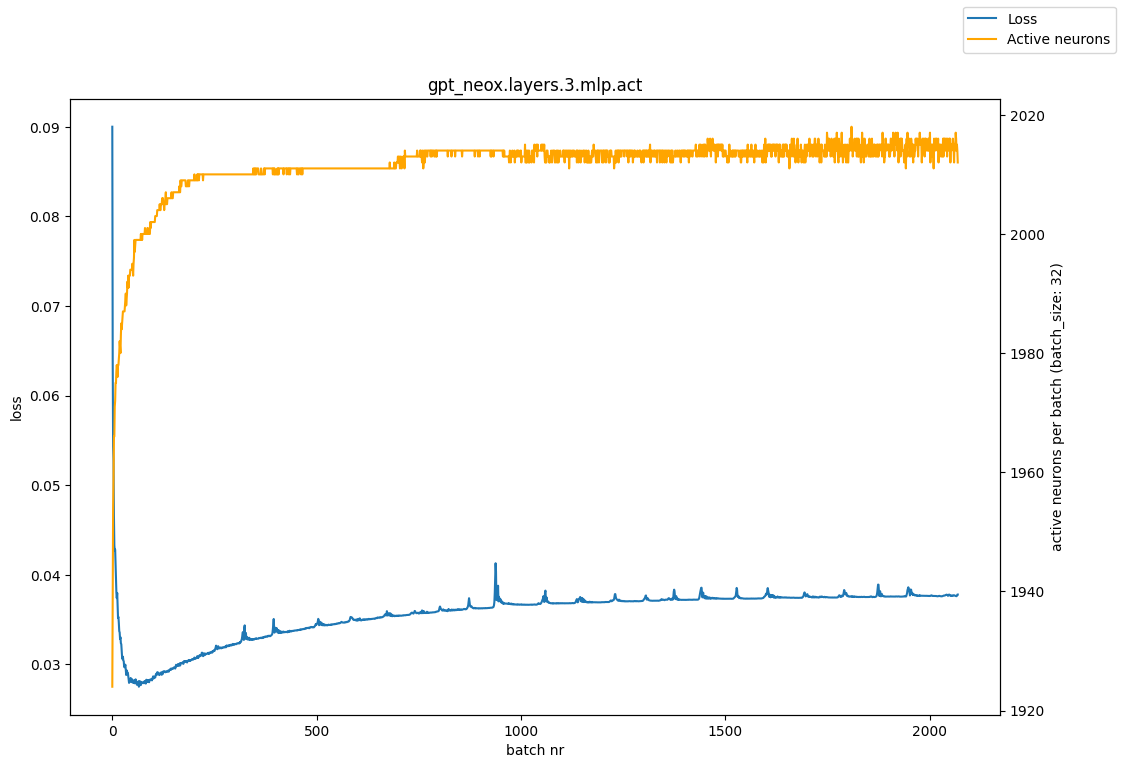

In [ ]:
for sae_trainers in sae_trainer_list
    for sae_trainer in sae_trainers:
        hookpoint = sae_trainer.hookpoint
        k = sae_trainer.model.k
        #base_name = f'{model_folder}/topk{k}/{hookpoint}'
        base_name = f"{hookpoint}_activation_function_{sae_trainer.meta_data["activation_function"]}_pre_encoder_bias_{sae_trainer.meta_data["pre_encoder_bias"]}"

        model_out_path = f'{model_folder}/topk{k}/{base_name}.pt'
        meta_data_out_path = f'{model_folder}/topk{k}/{base_name}.json'
        log_path_base = f"{log_folder}/topk{k}/"
        log_path_csv = f'{log_path_base}{base_name}.csv'
        log_fig_path = f'{log_path_base}{base_name}.png'


        if not os.path.isdir(f'{model_folder}'):
            os.mkdir(f'{model_folder}')
        if not os.path.isdir(f'{log_folder}'):
            os.mkdir(f'{log_folder}')

        if not os.path.isdir(f'{log_folder}'):
            os.mkdir(f'{log_folder}')
        if not os.path.isdir(f'{base_name}'):
            os.mkdir(f'{base_name}')

        torch.save(sae_trainer.model.state_dict(), model_out_path)

        new_meta = {key: value for key, value in meta_data.items()}
        new_meta['batch_size'] = batch_size
        new_meta['num_batches_trained_on'] = sae_trainer.batches
        new_meta['hookpoint'] = sae_trainer.hookpoint
        new_meta['learning_rate'] = learning_rate

        with open(meta_data_out_path, 'w') as file:
            json.dump(new_meta, file, indent=4)

        loss_log, active_neurons_log = zip(*sae_trainer.losses)
        df = pd.DataFrame({
            'loss': loss_log,
            'active_neurons': active_neurons_log
        })
        df.to_csv(log_path_csv)

        pd.DataFrame(d).to_csv(log_folder + "/grid_search.csv")

        sae_trainer.plot_loss(out_file=log_fig_path)

In [ ]:
# too big to commit :((((